# **TikTok Project**
**Course 6 - The Nuts and bolts of machine learning**

Recall that you are a data professional at TikTok. Your supervisor was impressed with the work you have done and has requested that you build a machine learning model that can be used to determine whether a video contains a claim or whether it offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.


# **Course 6 End-of-course project: Classifying videos using machine learning**

In this activity, you will practice using machine learning techniques to predict on a binary outcome variable.
<br/>

**The purpose** of this model is to increase response time and system efficiency by automating the initial stages of the claims process.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".
<br/>

*This activity has three parts:*

**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps




# **Classify videos using machine learning**


# **PACE stages**


Throughout these project notebooks, you'll see references to the problem-solving framework PACE. The following notebook components are labeled with the respective PACE stage: Plan, Analyze, Construct, and Execute.



## **PACE: Plan**

Consider the questions in your PACE Strategy Document to reflect on the Plan stage.

In this stage, consider the following questions:


1.   **What are you being asked to do? What metric should I use to evaluate success of my business/organizational objective?**

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported&mdash;too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

**Modeling design and target variable**

The data dictionary shows that there is a column called `claim_status`. This is a binary value that indicates whether a video is a claim or an opinion. This will be the target variable. In other words, for each video, the model should predict whether the video is a claim or an opinion.

This is a classification task because the model is predicting a binary class.

**Select an evaluation metric**

To determine which evaluation metric might be best, consider how the model might be wrong. There are two possibilities for bad predictions:

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim

2.   **What are the ethical implications of the model? What are the consequences of your model making errors?**
  *   What is the likely effect of the model when it predicts a false negative (i.e., when the model says a video does not contain a claim and it actually does)?

  *   What is the likely effect of the model when it predicts a false positive (i.e., when the model says a video does contain a claim and it actually does not)

In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.

3.   **How would you proceed?**

**Modeling workflow and model selection process**

Previous work with this data has revealed that there are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

<div style="text-align:center">
    <img src="https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg" width="60%">
</div>




### **Task 1. Imports and data loading**

Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

# Import packages for data modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# XGBoost
from xgboost import XGBClassifier
from xgboost import plot_importance


Now load the data from the provided csv file into a dataframe.


In [2]:
# Load dataset into dataframe
df = pd.read_csv("tiktok_dataset.csv")


## **PACE: Analyze**

Consider the questions in your PACE Strategy Document to reflect on the Analyze stage.

### **Task 2: Examine data, summary info, and descriptive stats**

Inspect the first five rows of the dataframe.

In [3]:
# Display first few rows
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Get the number of rows and columns in the dataset.

In [4]:
# Get number of rows and columns
df.shape

(19382, 12)

Get the data types of the columns.

In [5]:
# Get data types of columns
df.dtypes

,0
#,int64
claim_status,object
video_id,int64
video_duration_sec,int64
video_transcription_text,object
verified_status,object
author_ban_status,object
video_view_count,float64
video_like_count,float64
video_share_count,float64


Get basic information about the dataset.

In [6]:
# Get basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


Generate basic descriptive statistics about the dataset.

In [7]:
# Generate basic descriptive stats
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


Check for and handle missing values.

In [8]:
# Check for missing values
df.isna().mean()

,0
#,0.000000
claim_status,0.015375
video_id,0.000000
video_duration_sec,0.000000
video_transcription_text,0.015375
verified_status,0.000000
author_ban_status,0.000000
video_view_count,0.015375
video_like_count,0.015375
video_share_count,0.015375


In [9]:
# Drop rows with missing values
df = df.dropna(axis=0)
df.shape

(19084, 12)

In [10]:

# Display first few rows after handling missing values
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Check for and handle duplicates.

In [11]:
# Check for duplicates
df.duplicated().sum()

0

There are no duplicate in the dataset.

Check for and handle outliers.

From the result of `data.describe()`, there maybe outliers in the following variables:
- `video_view_count`
- `video_like_count`
- `video_share_count`
- `video_download_count`
- `video_comment_count`

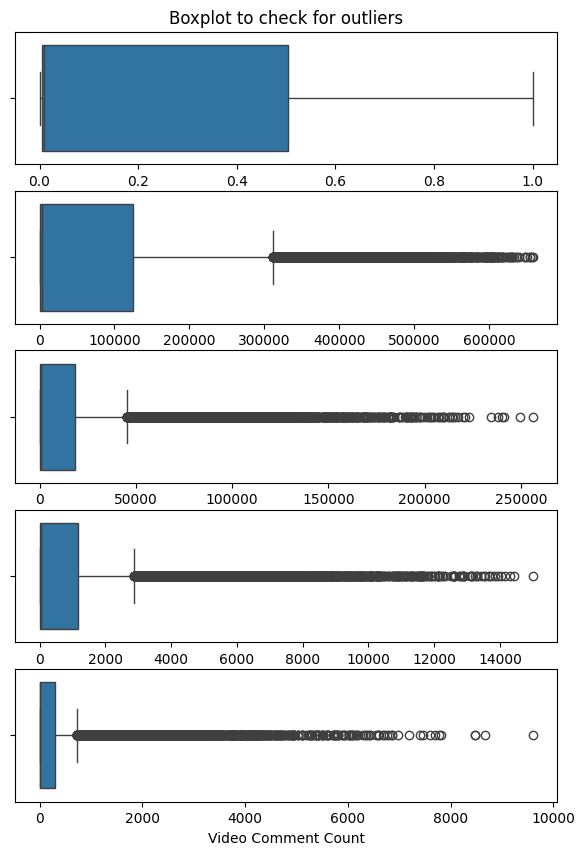

In [14]:
fig, axes = plt.subplots(5, 1, figsize=(7, 10))

sns.boxplot(data=df, x="video_view_count", orient="h", ax=axes[0])
sns.boxplot(data=df, x="video_like_count", orient="h", ax=axes[1])
sns.boxplot(data=df, x="video_share_count", orient="h", ax=axes[2])
sns.boxplot(data=df, x="video_download_count", orient="h", ax=axes[3])
sns.boxplot(data=df, x="video_comment_count", orient="h", ax=axes[4])

axes[0].set_title("Boxplot to check for outliers")
axes[0].set_xlabel("Video View Count")
axes[1].set_xlabel("Video Like Count")
axes[2].set_xlabel("Video Share Count")
axes[3].set_xlabel("Video Download Count")
axes[4].set_xlabel("Video Comment Count")
plt.show()


The figure shows there are outliers in `video_like_count`,`video_share_count`,`video_download_count` and `video_comment_count` features. Next we will handle it.

In [16]:
# Handle outlier in video like count
Q1 = df["video_like_count"].quantile(0.25)
Q3 = df["video_like_count"].quantile(0.75)

# Compute the interquantile range
IQR = Q3 - Q1
upper_limit = Q3 + 1.5*IQR
upper_limit
df.loc[df["video_like_count"] > upper_limit, "video_like_count"] = upper_limit

In [17]:
# Handle outlier in video share count
Q1 = df["video_download_count"].quantile(0.25)
Q3 = df["video_download_count"].quantile(0.75)

# Compute the interquantile range
IQR = Q3 - Q1
upper_limit = Q3 + 1.5*IQR
upper_limit
df.loc[df["video_download_count"] > upper_limit, "video_download_count"] = upper_limit

In [18]:
# Handle outlier in video share count
Q1 = df["video_share_count"].quantile(0.25)
Q3 = df["video_share_count"].quantile(0.75)

# Compute the interquantile range
IQR = Q3 - Q1
upper_limit = Q3 + 1.5*IQR
upper_limit
df.loc[df["video_share_count"] > upper_limit, "video_share_count"] = upper_limit

In [19]:
# Handle outlier in video comment count
Q1 = df["video_comment_count"].quantile(0.25)
Q3 = df["video_comment_count"].quantile(0.75)

# Compute the interquantile range
IQR = Q3 - Q1
upper_limit = Q3 + 1.5*IQR
upper_limit
df.loc[df["video_comment_count"] > upper_limit, "video_comment_count"] = upper_limit

Check class balance.

In [20]:
# Check class balance
df["claim_status"].value_counts(normalize=True)

,proportion
claim_status,
claim,0.503458
opinion,0.496542


The `claim_status` class is well balanced. There is no need to perform about class operation on this variable.
50% video content contains claims


## **PACE: Construct**
Consider the questions in your PACE Strategy Document to reflect on the Construct stage.

### **Task 3: Feature engineering**

Extract the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [21]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
df["text_length"] = df["video_transcription_text"].str.len()
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average text_length for claims and opinions.

In [22]:
# Calculate the average text_length for claims and opinions
df.groupby(["claim_status"])["text_length"].agg([("avg_txt_length", "mean")])


,avg_txt_length
claim_status,
claim,95.376978
opinion,82.722562


Visualize the distribution of `text_length` for claims and opinions.

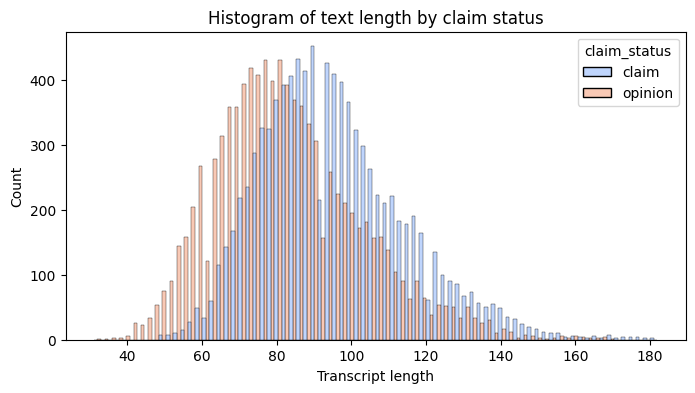

In [23]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot

plt.figure(figsize=(8,4))
sns.histplot(data=df, x="text_length", hue="claim_status", multiple="dodge", palette="coolwarm")
plt.title("Histogram of text length by claim status")
plt.xlabel("Transcript length");

**Feature selection and transformation**

Encode target and catgorical variables.

In [24]:
df.columns

Index(['#', 'claim_status', 'video_id', 'video_duration_sec',
       'video_transcription_text', 'verified_status', 'author_ban_status',
       'video_view_count', 'video_like_count', 'video_share_count',
       'video_download_count', 'video_comment_count', 'text_length'],
      dtype='object')

In [25]:
# Create a copy of the X data
X = df.copy()

# Drop unnecessary columns
X = X.drop(columns=["#", "video_id"], axis=1)

# Encode target variable
X["claim_status"] = X["claim_status"].map({"opinion": 0, "claim": 1})

# Dummy encode remaining categorical values
X = pd.get_dummies(X, columns=["verified_status", "author_ban_status"], drop_first=True)

X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


### **Task 4: Split the data**

Assign target variable.

In [26]:
# Isolate target variable
y = X["claim_status"]

Isolate the features.

In [27]:
# Isolate features
X = X.drop(["claim_status"], axis=1)

# Display first few rows of features dataframe
X.head()


,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


#### **Task 5: Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [28]:
# Split the data into training and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [29]:
# Futher split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [30]:
# Get shape of each training, validation, and testing set
print(f"Dimension of training set: {X_train.shape}")
print(f"Dimension of validation set: {X_val.shape}")
print(f"Dimension of test set: {X_test.shape}")

Dimension of training set: (11450, 11)
Dimension of validation set: (3817, 11)
Dimension of test set: (3817, 11)


### **Tokenize text column**

The feature `video_transcription_text` is text-based. The transcript can have different length, include nonwords, have spelling errors etc. We need a way to _featurize_ the feature.

The simplist and most common _featurization_ is **bag-of-words** model. We score each row for the presence and absence of each of the words in the English langauge dictionary. If the dictionary contains M words, that means for each document we create a binary feature
vector of length M, and score a 1 for every word present, and 0 otherwise.

The bag-of-words model summarizes a text by the words present, and ignores their context. One way to take the context into account is the bag-of-n-grams model.

One way to extract numerical features from it is through a bag-of-words algorithm like [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

`CountVectorizer` works by splitting text into n-grams, which are groups of n consecutive words. For instance, "a dime for a cup of coffee" (phrase A) broken into 2-grams would result in six two-word combinations:

`a dime` | `dime for` |`for a`| `a cup` | `cup of` | `of coffee` |

Then, the next sample's text would be parsed into 2-grams. So, "ask for a cup for a child" (phrase B) would result in:

`ask for` |`for a`| `a cup` | `cup for` | `for a` | `a child` |

This process would repeat for each observation in the dataset, and each n-gram would be treated like a distinct feature. Then, the text of each observation is compared to the full array of n-grams, and the numbers of occurrences are tallied:

|  | `a dime` |`dime for`  |`for a`| `a cup` | `cup of` | `of coffee` | `ask for` | `cup for` | `a child` |
|--: |:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|phrase A |1|1|1|1|1|1|0|0|0|
|phrase B |0|0|2|1|1|0|1|1|1|
|**TOTAL**|1|1|3|2|2|1|1|1|1|

This would happen for the text of each observation in the data, and the text of each observation is parsed to get tallies for all the 2-word phrases from the entire data set for each observation, creating a large matrix.

If text is broken into 1-grams, then each feature in the matrix is an individual word.

After the count matrix has been created, `CountVectorizer` lets you the choose to keep only the most frequently occurring n-grams. You specify how many. The n-grams that you select can then be used as features in a model.

Splitting text into n-grams is an example of tokenization. Tokenization is the process of breaking text into smaller units to derive meaning from the resulting tokens.

This notebook breaks each video's transcription text into both 2-grams and 3-grams, then takes the 15 most frequently occurring tokens from the entire dataset to use as features.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer as CV

# Instantiate the CountVectorizer
cv = CV()

Text1 = "Natural Language Processing is a subfield of AI"
tag1 = "NLP"

Text2 = "Computer Vision is a subfield of AI"
tag2 = "CV"

cv.fit([Text1, Text2])
x = cv.transform([Text1]).toarray()
y = cv.transform([Text2]).toarray()

columns = cv.get_feature_names_out()
df1 = pd.DataFrame(x, columns=columns, index=["Text1"])
df2 = pd.DataFrame(y, columns=columns, index=["Text2"])

df = pd.concat([df1, df2])
df["tag"] = [tag1, tag2]
df

,ai,computer,is,language,natural,of,processing,subfield,vision,tag
Text1,1,0,1,1,1,1,1,1,0,NLP
Text2,1,1,1,0,0,1,0,1,1,CV


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(norm=None)
tfidf.fit([Text1, Text2])

x = tfidf.transform([Text1]).toarray()
y = tfidf.transform([Text2]).toarray()

columns = tfidf.get_feature_names_out()

df1 = pd.DataFrame(x, columns=columns, index=["Text1"])
df2 = pd.DataFrame(y, columns=columns, index=["Text2"])

df = pd.concat([df1, df2], axis=0)

df

,ai,computer,is,language,natural,of,processing,subfield,vision
Text1,1.0,0.000000,1.0,1.405465,1.405465,1.0,1.405465,1.0,0.000000
Text2,1.0,1.405465,1.0,0.000000,0.000000,1.0,0.000000,1.0,1.405465


In [33]:
tfidf_vec = TfidfVectorizer(ngram_range=(2, 3),
              max_features=15,
              stop_words="english")
tfidf_vec

TfidfVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [34]:
# Extract the numerical features from `video_transcription_text` in the training set
count_data = tfidf_vec.fit_transform(X_train["video_transcription_text"]).toarray()
count_data

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        0.       ],
       [0.4692621, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [35]:
# Place the numerical representation of ``video_transcription_text` from the training set into a dataframe

count_df = pd.DataFrame(data=count_data, columns=tfidf_vec.get_feature_names_out())
count_df.head()

,colleague learned,colleague read,discussion board,forum claim,friend learned,friend read,internet forum,internet forum claim,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0.000000,0.0,0.0,0.000000,0.700285,0.0,0.000000,0.000000,0.713863,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
2,0.469262,0.0,0.0,0.532149,0.000000,0.0,0.461983,0.532149,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Concatenate X_train and count_df to form the final dataframe for trainin data
# Note: Using `.reset_index(drop=True` to reset the index in X_train after dropping `video_transcription_text`

X_train_final = pd.concat([X_train.drop(columns=["video_transcription_text"]).reset_index(drop=True), count_df], axis=1)

X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend read,internet forum,internet forum claim,learned media,media claim,news claim,point view,read media,social media,willing wager
0,55,254459.0,66996.0,2673.0,220.0,95.0,97,False,False,True,...,0.0,0.000000,0.000000,0.713863,0.0,0.0,0.0,0.0,0.0,0.0
1,40,433056.0,85389.0,13301.0,1766.0,1.0,110,False,False,True,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
2,29,997358.0,83574.0,17310.0,951.0,530.0,155,False,True,False,...,0.0,0.461983,0.532149,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,15,122973.0,53791.0,14407.0,257.0,8.0,89,False,True,False,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,17,948.0,309.0,61.0,8.0,2.0,77,True,False,False,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Get n-gram counts for the validation data.
The vectorizer is not being refit to the validation data. It's only transforming it. In other words, the transcriptions of the videos in the validation data are only being checked agains the n-grams found in the training data

In [37]:
validation_count_data = tfidf_vec.transform(X_val["video_transcription_text"]).toarray()
validation_count_data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.60160123,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [38]:
# Place the numerical representation of `video_transcription_text` from validation set in dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=tfidf_vec.get_feature_names_out())
validation_count_df.head()

,colleague learned,colleague read,discussion board,forum claim,friend learned,friend read,internet forum,internet forum claim,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0.0,0.0,0.0,0.0,0.583435,0.0,0.0,0.0,0.0,0.5456,0.0,0.0,0.0,0.601601,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,1.0


In [39]:
# Concatenate X_train and count_df to form the final dataframe for trainin data
# Note: Using `.reset_index(drop=True` to reset the index in X_train after dropping `video_transcription_text`

X_val_final = pd.concat([X_val.drop(columns=["video_transcription_text"]).reset_index(drop=True), validation_count_df], axis=1)

X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend read,internet forum,internet forum claim,learned media,media claim,news claim,point view,read media,social media,willing wager
0,34,761969.0,311333.875,45382.5,2880.125,728.5,98,False,False,False,...,0.0,0.0,0.0,0.0,0.5456,0.0,0.0,0.0,0.601601,0.0
1,54,4168.0,965.000,106.0,9.000,2.0,95,False,False,False,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0
2,43,8347.0,1684.000,134.0,39.000,7.0,84,False,False,False,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0
3,6,6902.0,2861.000,20.0,27.000,1.0,74,False,False,False,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0
4,20,37.0,8.000,1.0,0.000,0.0,96,False,False,False,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,1.0


In [40]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = tfidf_vec.transform(X_test["video_transcription_text"]).toarray()

test_count_df = pd.DataFrame(data=test_count_data, columns=tfidf_vec.get_feature_names_out())

# Concatenate X_test and test_count_df to form the final dataframe for testing data
X_test_final = pd.concat([X_test.drop(columns=["video_transcription_text"]
                                     ).reset_index(drop=True),test_count_df], axis=1)
X_test_final.head()


,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend read,internet forum,internet forum claim,learned media,media claim,news claim,point view,read media,social media,willing wager
0,22,6517.0,337.000,120.0,5.000,0.0,73,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,39,758131.0,41367.000,11288.0,774.000,143.0,83,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.722141,0.0
2,17,613559.0,311333.875,45382.5,2880.125,728.5,76,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,9,363966.0,196481.000,1246.0,1593.000,657.0,114,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,5,582955.0,86748.000,7182.0,865.000,21.0,98,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### **Task 6. Build models**


### **Build a decision tree model**

Fit a decision tree mode to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

**Baseline Model**

We'll first train a baseline model, just to get a sense of how predictive the data is and to give us scores that we can reference later. This will also show the process of instantiating and fitting the model, and then using it to make predictions. We'll predict on the test data.

In [41]:
# Instantiate the Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
decision_tree = DecisionTreeClassifier(random_state=0)

# Fit the model to training data
decision_tree.fit(X_train_final, y_train)

# Make prediction on test data
dt_pred = decision_tree.predict(X_test_final)

In [42]:
# Generate performance metrics
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.996
Precision: 0.997
Recall: 0.995
F1 Score: 0.996


**Analysis of baseline model**

**Confusion matrix**

Let's inspect the confusion matrix of our decision tree's predictions. First, we'll write a short helper function to help us display the matrix.

In [43]:
def conf_matrix_plot(model, x_data, y_data):
    """
    Accepts as argument model object, X data (test or validation),
    and y data (test or validation).
    Returns a plot of confusion matrix for predictions on y data."""
    ax = plt.subplots(figsize=(4,4))[1]
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot(values_format="", ax=ax)
    plt.show

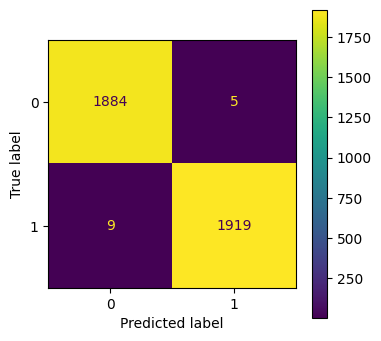

In [44]:
# Generate the confusion matrix for the base decision tree
conf_matrix_plot(decision_tree, X_test_final, y_test)

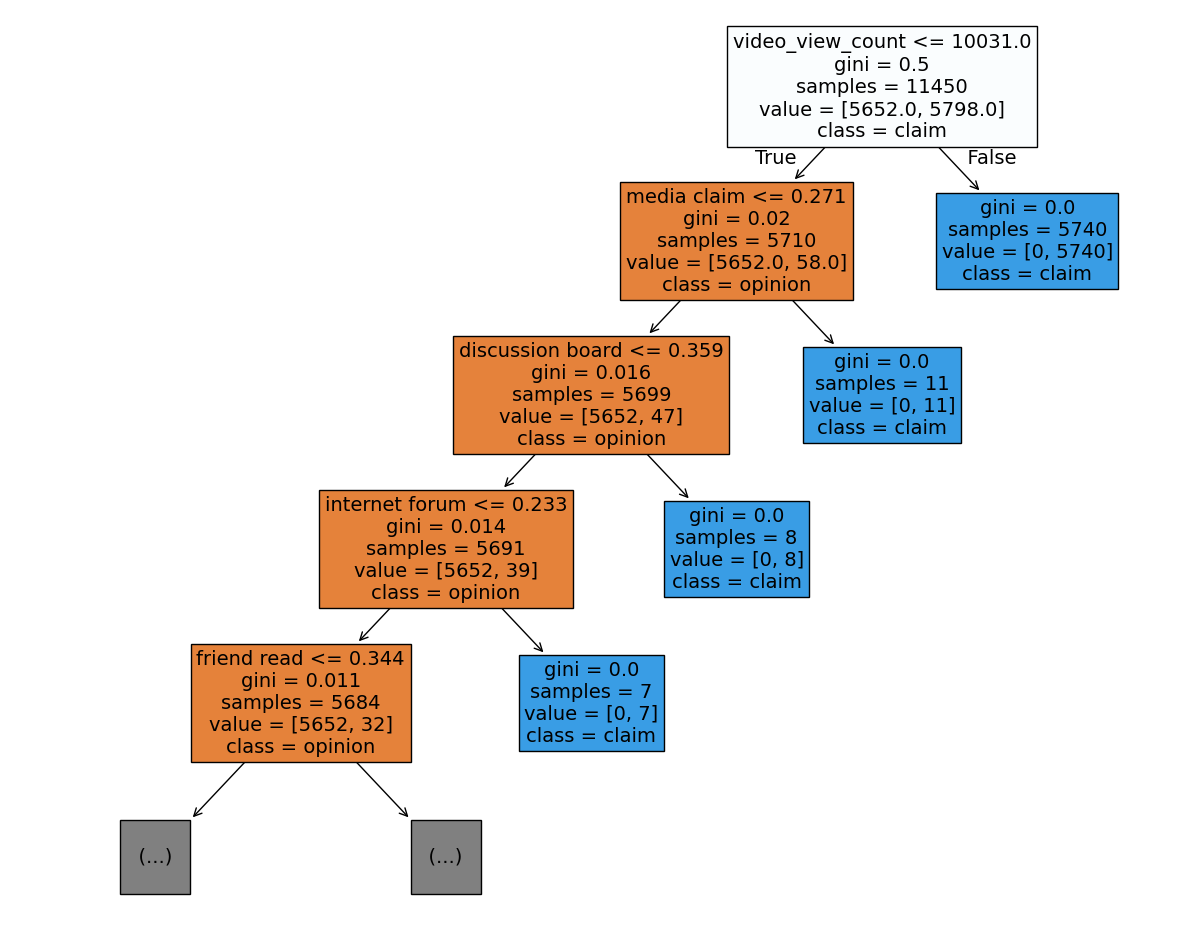

In [45]:
# Plot the tree
plt.figure(figsize=(15,12))
plot_tree(decision_tree, max_depth=4,
          fontsize=14,
          feature_names=X_train_final.columns,
         class_names={0:"opinion", 1:"claim"}, filled=True)
plt.show()

### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [60]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {"max_depth": [5, 7, None],
            "max_features": [0.3, 0.6],
            "max_samples": [0.6],
            "min_samples_leaf": [1,2,3],
            "min_samples_split": [2,3],
            "n_estimators": [100, 200]
            }


# Define a dictionary of scoring metrics to capture
scoring = ["accuracy", "precision", "recall", "f1"]

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, param_grid=cv_params, scoring=scoring, cv=5, refit="recall")


In [61]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: user 8min 22s, sys: 1.08 s, total: 8min 23s
Wall time: 8min 25s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.6], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 200]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [62]:
# Examine best recall score
rf_cv.best_score_


0.9955157537710868

In [63]:
# Estimate best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.3,
 'max_samples': 0.6,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 200}

In [64]:
best_index = rf_cv.best_index_
best_mean_precision = rf_cv.cv_results_["mean_test_precision"][best_index]
best_mean_precision

0.9994814174589456

The model performed well, with an average recall score of 0.995 across the five cross-validation folds. It is clear the model is making almost a perfect classification. This is always an indication of data leakage or some other issues

In [65]:
def make_results(model_name, model_object):
    """
    Accepts as arguments a mode name and a fit GridSerch model object

    Return a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.

    Parameters
    ==========
    model_name:  str
        Your prefered mode name
    model_object: Model
        Fitted Gridsearch model

    Return
    ======
    table: pd.DataFrame

    """
      # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(rf_cv.cv_results_)
    # Isolate the row of the df with the max(mean precision score)
    best_estimator_results = cv_results.iloc[cv_results["mean_test_precision"].idxmax(), :]
    # Extract accuracy, precision, recall, f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame({"Model": [model_name],
                         "F1": [f1],
                         "Recall": [recall],
                         "Precision": [precision],
                         "Accuracy": [accuracy]})
    return table




In [66]:
rf_df = make_results("Random Forest CV", rf_cv)
rf_df

,Model,F1,Recall,Precision,Accuracy
0,Random Forest CV,0.99619,0.992411,1.0,0.996157


In [67]:
# Examine best parameters
rf_cv.best_score_

0.9955157537710868

## Pickle  

When models take a long time to fit, you don’t want to have to fit them more than once. If your kernel disconnects or you shut down the notebook and lose the cell’s output, you’ll have to refit the model, which can be frustrating and time-consuming.

`pickle` is a tool that saves the fit model object to a specified location, then quickly reads it back in. It also allows you to use models that were fit somewhere else, without having to train them yourself.

In [68]:
import pickle
# Pickle the model
with open("rf_cv_model.pickle", "wb") as to_write:
    pickle.dump(rf_cv, to_write)

In [69]:
# Test reading the model
with open("rf_cv_model.pickle", "rb") as read_to:
    rf_cv = pickle.load(read_to)

**Question:** How well is your model performing? Consider average recall score and precision score.

### **Build an XGBoost model**

Generally, Xgboost parameters have been divided into 4 categories: General, Booster, Learning task and Command line parameters

In [70]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective="binary:logistic", random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {"max_depth": [3,7,10],
             "min_child_weight": [0, 3, 5, 10],
             "learning_rate": [0.01, 0.1],
             "n_estimators": [80, 300, 500],
             "subsample" : [0.8, 1]
             }

# Define a dictionary of scoring metrics to capture
scoring = ["accuracy", "precision", "recall", "f1"]

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, param_grid=cv_params, scoring=scoring, refit="recall")

In [71]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: user 12min 33s, sys: 6.26 s, total: 12min 39s
Wall time: 7min 26s


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 7, 10],
                         'min_child_weight': [0, 3, 5, 10],
                         'n_estimators': [80, 300, 500],
                         'subsample': [0.8, 1]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [72]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 0,
 'n_estimators': 80,
 'subsample': 1}

In [73]:
xgb_cv.best_score_

0.9949986611525989

In [74]:
#Save the model as a pickle file
# Pickle the model
with open("xgb_cv_model.pickle", "wb") as to_write:
    pickle.dump(xgb_cv, to_write)

In [75]:
  # Get all the results from the CV and put them in a df
xgb_df = make_results("XGBoost CV", xgb_cv)
xgb_df


,Model,F1,Recall,Precision,Accuracy
0,XGBoost CV,0.99619,0.992411,1.0,0.996157


In [76]:
pd.concat([rf_df, xgb_df])

,Model,F1,Recall,Precision,Accuracy
0,Random Forest CV,0.99619,0.992411,1.0,0.996157
0,XGBoost CV,0.99619,0.992411,1.0,0.996157


This model also performed exceptionally well. With identical result as the Random forest.

**Question:** How well does your model perform? Consider recall score and precision score.


## **PACE: Execute**
Consider the questions in your PACE Strategy Document to reflect on the Execute stage.

### **Task 7. Evaluate model**

Evaluate models against validation criteria.

#### **Random forest**

In [77]:
# Use the random forest "best estimator" model to get predictions on the encoded testing set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

Display the predictions on the encoded testing set.

In [78]:
# Display the predictions on the encoded testing set
y_pred

array([1, 0, 0, ..., 0, 0, 1])

Display the true labels of the testing set.

In [79]:
y_val

,claim_status
1871,1
16574,0
17741,0
17214,0
17821,0
...,...
15929,0
12177,0
18295,0
17339,0


Create a confusion matrix to visualize the results of the classification model.

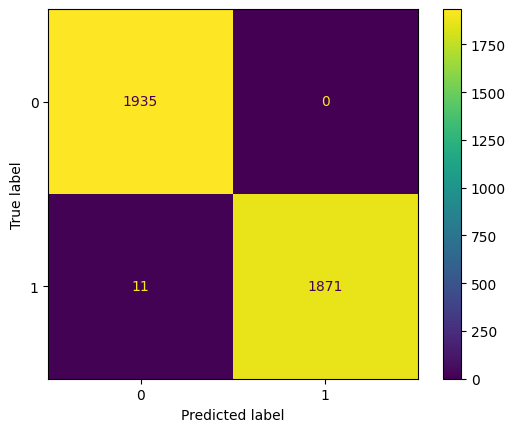

In [80]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
cm = confusion_matrix(y_val, y_pred,labels=rf_cv.classes_)

# Create display of confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_cv.classes_)

# Plot confusion matrix
disp.plot()
# Display plot
plt.show()


The upper-left quadrant displays the number of true negative (TN): The number of opinions that the model accurately classified as so

The upper-right quandrant displays the number of false positives (FP): The number of opinions that the model misclassified as claim

The lower-left quandrant displays the number of false negative (FN): The number of claims that the model missclassified as opinions


The lower-right quandrant displays the number of true positve (TP): The number of claims that the model classified as claims.


As the above confusion matrix shows,this model does not produce a false positves.

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

In [81]:
# Create a classification report
# Create classification report for random forest model
target_labels = ["opinion", "claim"]
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1935
       claim       1.00      0.99      1.00      1882

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



**Question:** What does your classification report show? What does the confusion matrix indicate?

The classification report above shows that the random forest model score were nearly perfect. The confusion matrix show there were 11 misclassifications--false negatives and zero false positives

#### **XGBoost**

In [82]:
#Evaluate XGBoost model
### YOUR CODE HERE ###
y_pred = xgb_cv.best_estimator_.predict(X_val_final)
y_pred

array([1, 0, 0, ..., 0, 0, 1])

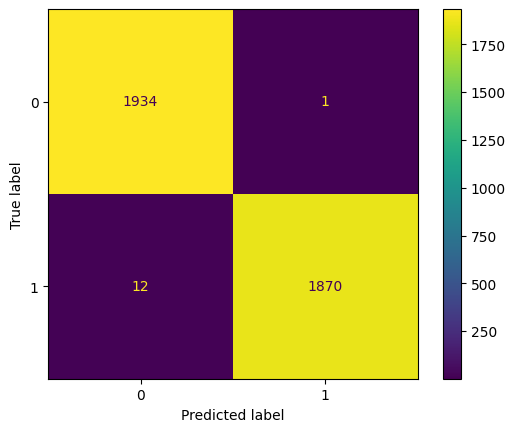

In [83]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
cm = confusion_matrix(y_val, y_pred,labels=xgb_cv.classes_)

# Create display of confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv.classes_)

# Plot confusion matrix
disp.plot()
# Display plot
plt.show()

In [84]:
# Create a classification report
# Create classification report for random forest model
target_labels = ["opinion", "claim"]
print(classification_report(y_val, y_pred, target_names=target_labels))


              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1935
       claim       1.00      0.99      1.00      1882

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



**Question:** Describe your XGBoost model results. How does your XGBoost model compare to your random forest model?

The XGBoost model performed exceptionally well. However, it exhibited a tendency towards false negatives. Since the primary goal was to identify claim videos accurately, it is crucial for the model to capture all actual claim videos. The random forest model, with its superior recall score, was better at identifying claim videos and therefore emerged as the preferred model.

### **Use champion model to predict on test data**

Both Random forest and XGBoist model archetectures resulted in nearly perfect models, in this case random forest performed a little better , so it is the champion model

In [85]:
y_pred = rf_cv.best_estimator_.predict(X_test_final)

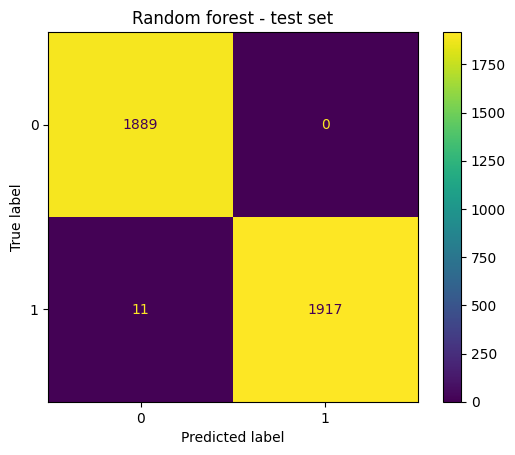

In [86]:
# Compute values for confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_cv.classes_)

# Create display of confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_cv.classes_)

# Plot confusion matrix
disp.plot()

# Display plot
plt.title("Random forest - test set")
plt.show()


#### **Feature importances of champion model**


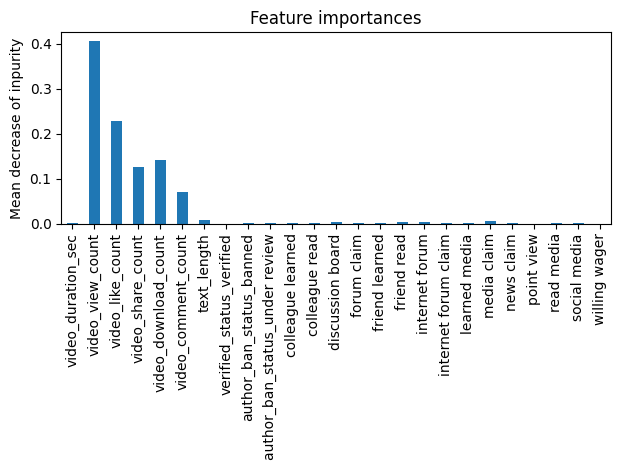

In [87]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_train_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease of inpurity")
fig.tight_layout()

**Question:** Describe your most predictive features. Were your results surprising?

The most important features were all related to the engagement levels generated by the video. This includes metrics such as view count, like count, share count, and comment count. This result is not surprising, as prior Exploratory Data Analysis (EDA) indicated a strong correlation between engagement metrics and the outcomes we were predicting. This aligns with the expectation that higher engagement levels are significant indicators of the content's impact and relevance.



### **Task 8. Conclusion**

In this step use the results of the models above to formulate a conclusion. Consider the following questions:

1. **Would you recommend using this model? Why or why not?**

2. **What was your model doing? Can you explain how it was making predictions?**

3. **Are there new features that you can engineer that might improve model performance?**

4. **What features would you want to have that would likely improve the performance of your model?**

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.


1. Would you recommend using this model? Why or why not?
* Yes, I would recommend using this model because it performed well on both the validation and test holdout data. Additionally, both the F1 and precision scores were consistently high, indicating reliable performance in classifying claims and opinions.

2. What was your model doing? Can you explain how it was making predictions?
* The model's predictions were primarily based on user engagement levels associated with each video, as indicated by the feature importance analysis. The most predictive features included the number of views, likes, shares, and downloads a video received. The model classified videos based on these engagement metrics.

3. Are there new features that you can engineer that might improve model performance?
* Given the model's exceptional performance, there is no immediate need to engineer additional features to improve it.

4. What features would you want to have that would likely improve the performance of your model?
* Although the model's performance is already exceptional, having the number of times a video was reported could potentially provide valuable insights and further enhance the model's accuracy.

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.